<a href="https://colab.research.google.com/github/AnkurP771/Transformers-Soil-Data/blob/main/Transformer_project_soil_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import pandas as pd
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import torch.nn.functional as F
import math



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Loading the dataset without headers
import pandas as pd

# Load the dataset with whitespace separation using sep='\s+'
data = pd.read_csv('/content/drive/MyDrive/Project/simulation_data_final.csv')

# Assign column names: u1 to u7 and y
# Preview the dataset
print(data.head(10))




   Irrigation  SoilMoisture
0    0.000007      0.415582
1    0.000007      0.418537
2    0.000007      0.420380
3    0.000007      0.422251
4    0.000007      0.424674
5    0.000007      0.427896
6    0.000007      0.427896
7    0.000007      0.427891
8    0.000004      0.419680
9    0.000004      0.419974


In [ ]:
data.describe()

,Irrigation,SoilMoisture
count,1.007200e+04,10072.000000
mean,5.143876e-06,0.434160
std,2.853143e-06,0.009537
min,1.030000e-07,0.415582
25%,2.680000e-06,0.425783
50%,5.250000e-06,0.432071
75%,7.610000e-06,0.441560
max,9.990000e-06,0.458741


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10072 entries, 0 to 10071
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Irrigation    10072 non-null  float64
 1   SoilMoisture  10072 non-null  float64
dtypes: float64(2)
memory usage: 157.5 KB


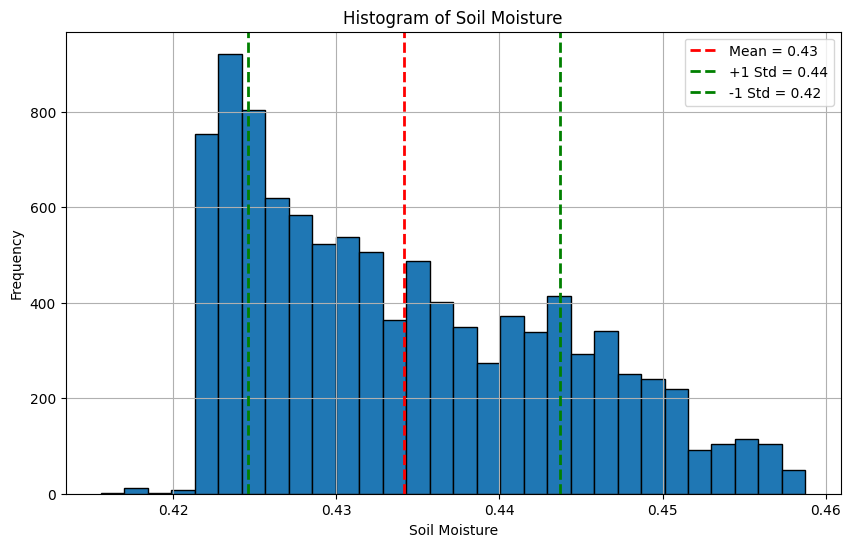


Data with Z-Score:
    Irrigation  SoilMoisture    zscore
0    0.000007      0.415582 -1.948016
1    0.000007      0.418537 -1.638139
2    0.000007      0.420380 -1.444962
3    0.000007      0.422251 -1.248694
4    0.000007      0.424674 -0.994617


In [ ]:
#Data Cleaning

#I will check for outlier in the output with the help of zscores

y = data['SoilMoisture']

# Step 5: Calculate Mean and Standard Deviation
mean = np.mean(y)
std = np.std(y)

# Step 6: Plot Histogram with Mean and Std Dev
plt.figure(figsize=(10, 6))
plt.hist(y, bins=30, edgecolor='black')  # 30 bins for detail
plt.axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean = {mean:.2f}')
plt.axvline(mean + std, color='green', linestyle='dashed', linewidth=2, label=f'+1 Std = {mean + std:.2f}')
plt.axvline(mean - std, color='green', linestyle='dashed', linewidth=2, label=f'-1 Std = {mean - std:.2f}')
plt.title("Histogram of Soil Moisture")
plt.xlabel("Soil Moisture")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

data["zscore"] = stats.zscore(y)

# Step 8: Preview Updated DataFrame
print("\nData with Z-Score:\n", data.head())


In [ ]:

data_new = data[  (data["zscore"]>3) | (data["zscore"]<-3) ]

#Hence there are no outliers in the dataset that must be removed
#data remains same

data.isna().sum()
#Hence there are no null values

,0
Irrigation,0
SoilMoisture,0
zscore,0


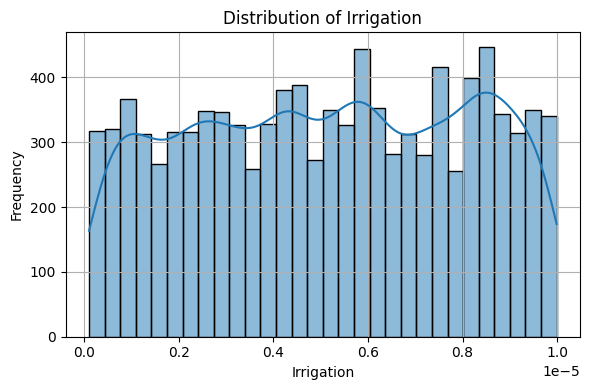

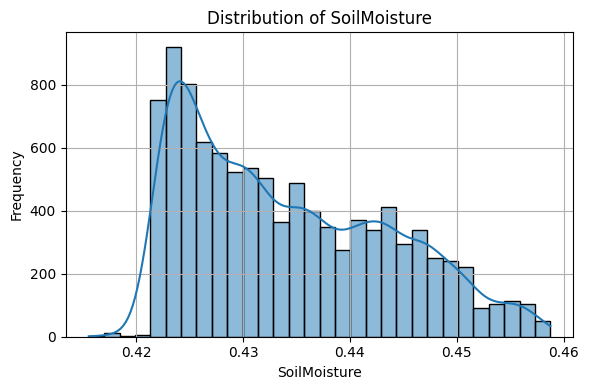

In [ ]:
for col in ['Irrigation', 'SoilMoisture']:
    plt.figure(figsize=(6, 4))
    sns.histplot(data[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()



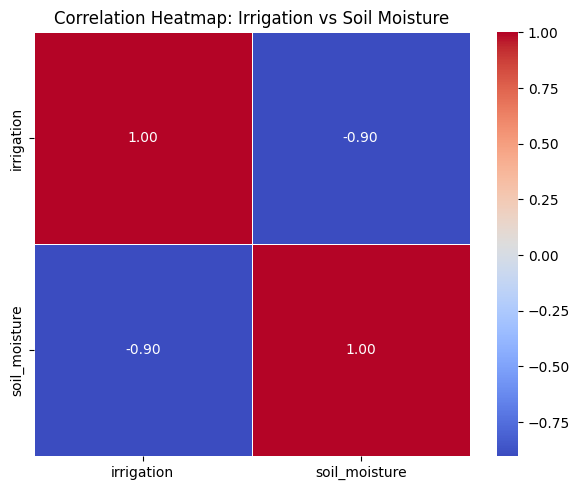

,irrigation,soil_moisture,zscore
0,0.000007,0.415582,-1.948016
1,0.000007,0.418537,-1.638139
2,0.000007,0.420380,-1.444962
3,0.000007,0.422251,-1.248694
4,0.000007,0.424674,-0.994617
...,...,...,...
10067,0.000008,0.424380,-1.025492
10068,0.000008,0.424380,-1.025492
10069,0.000008,0.424380,-1.025492
10070,0.000008,0.424380,-1.025492


In [ ]:
data.columns = ['irrigation', 'soil_moisture','zscore']

# Compute correlation matrix (only for these two columns)
corr = data[['irrigation', 'soil_moisture']].corr()

# Plot the heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap: Irrigation vs Soil Moisture")
plt.tight_layout()
plt.show()
data


In [ ]:
#The final cleaned dataset is data_new

!pip install torchvision



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]


In [ ]:
# Feedforward network used inside Transformer
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=2048, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        return self.linear2(self.dropout(F.relu(self.linear1(x))))

In [ ]:
# Encoder Layer
class EncoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embed_dim)
        )
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, src):
        # Here Im just making sure that src is 3D: [batch_size, seq_len, embed_dim]
        if src.dim() == 4:
            src = src.squeeze(1)  # or adjust as necessary
        attn_output, _ = self.self_attn(src, src, src)
        src = self.norm1(src + self.dropout(attn_output))
        ff_output = self.ffn(src)
        src = self.norm2(src + self.dropout(ff_output))
        return src


In [ ]:
# Decoder Layer
class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, n_heads, dropout=dropout)
        self.cross_attn = nn.MultiheadAttention(d_model, n_heads, dropout=dropout)
        self.ffn = FeedForward(d_model, d_ff, dropout)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, tgt, memory):
        tgt_mask = torch.triu(torch.ones(tgt.size(0), tgt.size(0)) * float('-inf'), diagonal=1).to(tgt.device)
        tgt2, _ = self.self_attn(tgt, tgt, tgt, attn_mask=tgt_mask)
        tgt = self.norm1(tgt + self.dropout(tgt2))

        tgt2, _ = self.cross_attn(tgt, memory, memory)
        tgt = self.norm2(tgt + self.dropout(tgt2))

        tgt2 = self.ffn(tgt)
        tgt = self.norm3(tgt + self.dropout(tgt2))
        return tgt


In [ ]:
# Full Transformer Model
class Transformer(nn.Module):
    def __init__(self, input_dim, output_dim, d_model=64, n_heads=4, num_layers=3, d_ff=256, dropout=0.1, max_len=100):
        super().__init__()
        self.input_embed = nn.Linear(input_dim, d_model)
        self.output_embed = nn.Linear(output_dim, d_model)

        self.pos_encoder = PositionalEncoding(d_model, max_len)
        self.pos_decoder = PositionalEncoding(d_model, max_len)

        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(num_layers)])

        self.fc_out = nn.Linear(d_model, output_dim)
        #self.softmax = nn.Softmax(dim=-1)

    def forward(self, src, tgt):
        src = self.input_embed(src)
        tgt = self.output_embed(tgt)

        src = self.pos_encoder(src)
        tgt = self.pos_decoder(tgt)

        for layer in self.encoder_layers:
            src = layer(src)

        for layer in self.decoder_layers:
            tgt = layer(tgt, src)

        output = self.fc_out(tgt)
        return output

In [ ]:
# Simulated example
model = Transformer(input_dim=1, output_dim=1)

# Suppose irrigation is the input and soil moisture is the target
irrigation = torch.tensor([[0.000007], [0.000007], [0.000004]]).unsqueeze(1)  # (seq_len, batch, input_dim)
soil_moisture = torch.tensor([[0.41], [0.42], [0.43]]).unsqueeze(1)  # (seq_len, batch, output_dim)

# Reshape for transformer input: (seq_len, batch, input_dim)
irrigation = irrigation.permute(1, 0, 2)
soil_moisture = soil_moisture.permute(1, 0, 2)

predicted = model(irrigation, soil_moisture)
print(predicted)

tensor([[[-0.2392],
         [ 0.0452],
         [ 0.2038]]], grad_fn=<ViewBackward0>)


In [ ]:
# ---------- Dataset Class ----------
from torch.utils.data import Dataset
import torch
data = data[["irrigation","soil_moisture"]]
class IrrigationDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Return shape (seq_len=1, feature_dim=1)
        x = self.X[idx].view(1, 1)
        y = self.y[idx].view(1, 1)
        return x, y



In [ ]:
# ---------- Load Data ----------
from sklearn.model_selection import train_test_split

df = pd.read_csv("/content/drive/MyDrive/Project/simulation_data_final.csv")  # Replace with your actual file
X = df["Irrigation"].values
y = df["SoilMoisture"].values

# Normalize for training stability
X_min, X_max = X.min(), X.max()
y_min, y_max = y.min(), y.max()

X_norm = (X - X_min) / (X_max - X_min)
y_norm = (y - y_min) / (y_max - y_min)

X_train, X_test, y_train, y_test = train_test_split(X_norm, y_norm, test_size=0.2, random_state=42)

train_dataset = IrrigationDataset(X_train, y_train)
test_dataset = IrrigationDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1)

In [ ]:
import torch
import torch.optim as optim


# Automatically use GPU if available, otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


evice = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Transformer(1, 1).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


epochs = 100
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for src, tgt in train_loader:
        src, tgt = src.to(device), tgt.to(device)
        output = model(src, tgt)
        loss = criterion(output, tgt)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.6f}")

Epoch 10/100, Loss: 0.000405
Epoch 20/100, Loss: 0.000110
Epoch 30/100, Loss: 0.000048
Epoch 40/100, Loss: 0.000015
Epoch 50/100, Loss: 0.000006
Epoch 60/100, Loss: 0.000007
Epoch 70/100, Loss: 0.000006
Epoch 80/100, Loss: 0.000005
Epoch 90/100, Loss: 0.000004
Epoch 100/100, Loss: 0.000004


In [ ]:
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for src, tgt in test_loader:
        src, tgt = src.to(device), tgt.to(device)
        output = model(src, tgt)
        predictions.append(output.squeeze().cpu().item())
        actuals.append(tgt.squeeze().cpu().item())

# Unnormalize predictions and actuals
predictions = np.array(predictions) * (y_max - y_min) + y_min
actuals = np.array(actuals) * (y_max - y_min) + y_min

# Calculate R2 Score
r2 = round(r2_score(actuals, predictions)*100,9)
print(f"R² Score on Test Set: {r2:.4f}")

R² Score on Test Set: 99.9932


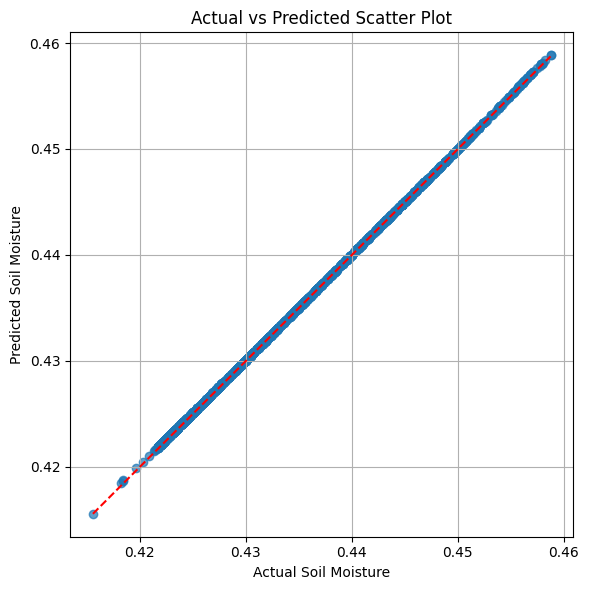

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(actuals, predictions, alpha=0.7)
plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'r--')  # 45-degree reference line
plt.xlabel("Actual Soil Moisture")
plt.ylabel("Predicted Soil Moisture")
plt.title("Actual vs Predicted Scatter Plot")
plt.grid(True)
plt.tight_layout()
plt.show()


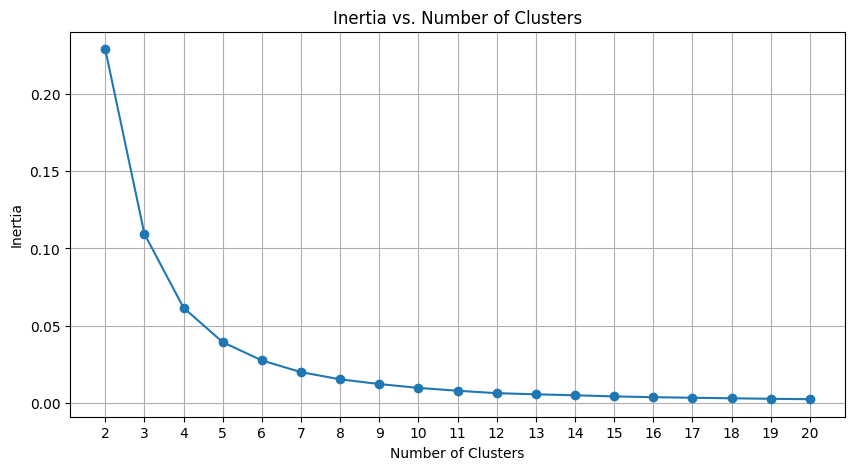

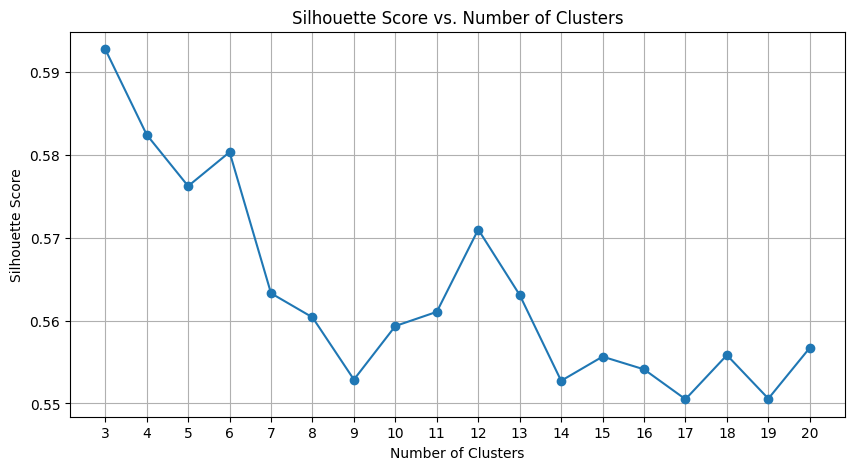

In [ ]:
#Hence we are done with overall transformer model, Now we will find optimal number of clusters and form trasformer model according to out clusters
X_clustering = data[['irrigation', 'soil_moisture']].values
X_clustering = data[['irrigation', 'soil_moisture']].values

# Lists to store inertia and silhouette scores
inertia_scores = []
silhouette_scores = []
cluster_range = range(2, 21)  # Cluster range from 2 to 20

# Calculate inertia and silhouette scores for each cluster number
for num_clusters in cluster_range:
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10) # Explicitly set n_init
    kmeans.fit(X_clustering)

    # Inertia (Within-cluster sum of squares)
    inertia_scores.append(kmeans.inertia_)

    # Silhouette Score (requires at least 2 clusters and more than 1 sample)
    if num_clusters > 1 and len(X_clustering) > 1:
        from sklearn.metrics import silhouette_score
        silhouette_avg = silhouette_score(X_clustering, kmeans.labels_)
        silhouette_scores.append(silhouette_avg)
    else:
        silhouette_scores.append(np.nan) # Append NaN if silhouette score is not applicable

# Plot Inertia curve
plt.figure(figsize=(10, 5))
plt.plot(cluster_range, inertia_scores, marker='o')
plt.title('Inertia vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.xticks(cluster_range)
plt.grid(True)
plt.show()

# Plot Silhouette score curve
plt.figure(figsize=(10, 5))
# Adjust the cluster range for plotting silhouette scores (starts from 2)
plt.plot(cluster_range[1:] if len(cluster_range) > 1 else cluster_range, silhouette_scores[1:] if len(silhouette_scores) > 1 else silhouette_scores, marker='o')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(cluster_range[1:] if len(cluster_range) > 1 else cluster_range)
plt.grid(True)
plt.show()



In [ ]:
#Hence optimum value for number of clusters is 3, as it has highest silhoutte score, ie, closest to 1,
#and it also shows shap bend at 3 for inertia curve

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans.fit(X_clustering)  # Use the same data used for finding optimal clusters

# Get the cluster labels for each data point
cluster_labels = kmeans.labels_

# Create a new DataFrame data1 by copying the original data
data1 = data.copy()

# Add a new column 'cluster' to data1 containing the cluster labels
data1['cluster'] = cluster_labels
data.head()

,irrigation,soil_moisture
0,0.000007,0.415582
1,0.000007,0.418537
2,0.000007,0.420380
3,0.000007,0.422251
4,0.000007,0.424674


In [ ]:
if 'data1' not in locals():
    print("Data with cluster labels ('data1') not found. Please run the previous cell to create it.")
else:
    # Split data by cluster
    cluster_dataframes = {}
    for cluster_id in data1['cluster'].unique():
        cluster_dataframes[cluster_id] = data1[data1['cluster'] == cluster_id].copy()
        print(f"Cluster {cluster_id} has {len(cluster_dataframes[cluster_id])} data points.")

    # Dictionary to store results for each cluster
    cluster_results = {}

    # Loop through each cluster and train/evaluate a Transformer model
    for cluster_id, cluster_df in cluster_dataframes.items():
        print(f"\n--- Training Transformer for Cluster {cluster_id} ---")

        # Prepare data for this cluster
        X_cluster = cluster_df["irrigation"].values
        y_cluster = cluster_df["soil_moisture"].values


Cluster 1 has 4630 data points.
Cluster 2 has 3023 data points.
Cluster 0 has 2419 data points.

--- Training Transformer for Cluster 1 ---

--- Training Transformer for Cluster 2 ---

--- Training Transformer for Cluster 0 ---


In [ ]:
# Normalize for training stability (normalize within each cluster)
X_min_cluster, X_max_cluster = X_cluster.min(), X_cluster.max()
y_min_cluster, y_max_cluster = y_cluster.min(), y_cluster.max()

X_norm_cluster = (X_cluster - X_min_cluster) / (X_max_cluster - X_min_cluster)
y_norm_cluster = (y_cluster - y_min_cluster) / (y_max_cluster - y_min_cluster)

# Split data for this cluster
X_train_cluster, X_test_cluster, y_train_cluster, y_test_cluster = train_test_split(
    X_norm_cluster, y_norm_cluster, test_size=0.2, random_state=42
)


In [ ]:
# Create Dataset and DataLoader for this cluster
train_dataset_cluster = IrrigationDataset(X_train_cluster, y_train_cluster)
test_dataset_cluster = IrrigationDataset(X_test_cluster, y_test_cluster)

train_loader_cluster = DataLoader(train_dataset_cluster, batch_size=16, shuffle=True)
test_loader_cluster = DataLoader(test_dataset_cluster, batch_size=1)

In [ ]:
# Instantiate and train Transformer model for this cluster
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_cluster = Transformer(1, 1).to(device)
criterion_cluster = nn.MSELoss()
optimizer_cluster = optim.Adam(model_cluster.parameters(), lr=0.001)

epochs_cluster = 100
for epoch in range(epochs_cluster):
    model_cluster.train()
    epoch_loss_cluster = 0
    for src, tgt in train_loader_cluster:
        src, tgt = src.to(device), tgt.to(device)
        output = model_cluster(src, tgt)
        loss = criterion_cluster(output, tgt)
        optimizer_cluster.zero_grad()
        loss.backward()
        optimizer_cluster.step()
        epoch_loss_cluster += loss.item()
    if (epoch + 1) % 20 == 0: # Print loss less frequently for brevity
          print(f"  Epoch {epoch+1}/{epochs_cluster}, Loss: {epoch_loss_cluster/len(train_loader_cluster):.6f}")


  Epoch 20/100, Loss: 0.000901
  Epoch 40/100, Loss: 0.000395
  Epoch 60/100, Loss: 0.000102
  Epoch 80/100, Loss: 0.000094
  Epoch 100/100, Loss: 0.000046


In [ ]:
# Evaluate the model for this cluster
model_cluster.eval()
predictions_cluster = []
actuals_cluster = []

with torch.no_grad():
    for src, tgt in test_loader_cluster:
        src, tgt = src.to(device), tgt.to(device)
        output = model_cluster(src, tgt)
        predictions_cluster.append(output.squeeze().cpu().item())
        actuals_cluster.append(tgt.squeeze().cpu().item())


R² Score for Cluster 0 on Test Set: 0.9996


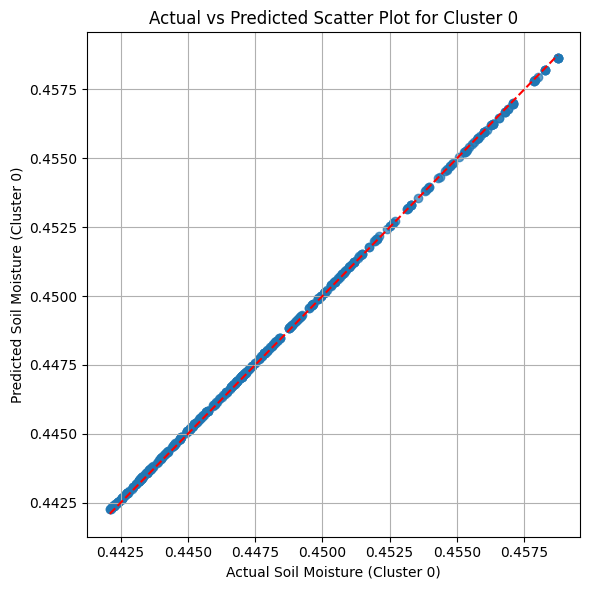


--- Training and Evaluation for all clusters completed ---


In [ ]:
# Unnormalize predictions and actuals for this cluster
predictions_cluster = np.array(predictions_cluster) * (y_max_cluster - y_min_cluster) + y_min_cluster
actuals_cluster = np.array(actuals_cluster) * (y_max_cluster - y_min_cluster) + y_min_cluster

# Calculate R2 Score for this cluster
r2_cluster = r2_score(actuals_cluster, predictions_cluster)
print(f"R² Score for Cluster {cluster_id} on Test Set: {r2_cluster:.4f}")

# Store results
cluster_results[cluster_id] = {
    'actuals': actuals_cluster,
    'predictions': predictions_cluster,
    'r2': r2_cluster
}

# Plot Actual vs Predicted for this cluster
plt.figure(figsize=(6, 6))
plt.scatter(actuals_cluster, predictions_cluster, alpha=0.7)
plt.plot([min(actuals_cluster), max(actuals_cluster)], [min(actuals_cluster), max(actuals_cluster)], 'r--')  # 45-degree reference line
plt.xlabel(f"Actual Soil Moisture (Cluster {cluster_id})")
plt.ylabel(f"Predicted Soil Moisture (Cluster {cluster_id})")
plt.title(f"Actual vs Predicted Scatter Plot for Cluster {cluster_id}")
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n--- Training and Evaluation for all clusters completed ---")
# You can access results for each cluster using cluster_results dictionary
# Example: print(cluster_results[0]['r2'])

In [ ]:
# # %%
# # Ensure data1 with cluster labels is available% Remove this
# if 'data1' not in locals():
#     print("Data with cluster labels ('data1') not found. Please run the previous cell to create it.")
# else:
#     # Split data by cluster
#     cluster_dataframes = {}
#     for cluster_id in data1['cluster'].unique():
#         cluster_dataframes[cluster_id] = data1[data1['cluster'] == cluster_id].copy()
#         print(f"Cluster {cluster_id} has {len(cluster_dataframes[cluster_id])} data points.")

#     # Dictionary to store results for each cluster
#     cluster_results = {}

#     # Loop through each cluster and train/evaluate a Transformer model
#     for cluster_id, cluster_df in cluster_dataframes.items():
#         print(f"\n--- Training Transformer for Cluster {cluster_id} ---")

#         # ... (Code for preparing data, splitting, creating DataLoader) ...

#         # Instantiate and train Transformer model for this cluster
#         # ... (Code for model instantiation, criterion, optimizer, and training loop) ...

#         # Evaluate the model for this cluster
#         model_cluster.eval()
#         predictions_cluster = []
#         actuals_cluster = []

#         with torch.no_grad():
#             for src, tgt in test_loader_cluster:
#                 src, tgt = src.to(device), tgt.to(device)
#                 output = model_cluster(src, tgt)
#                 predictions_cluster.append(output.squeeze().cpu().item())
#                 actuals_cluster.append(tgt.squeeze().cpu().item())

#         # --- THIS BLOCK NEEDS TO BE INSIDE THE LOOP ---
#         # Unnormalize predictions and actuals for this cluster
#         predictions_cluster = np.array(predictions_cluster) * (y_max_cluster - y_min_cluster) + y_min_cluster
#         actuals_cluster = np.array(actuals_cluster) * (y_max_cluster - y_min_cluster) + y_min_cluster

#         # Calculate R2 Score for this cluster
#         r2_cluster = r2_score(actuals_cluster, predictions_cluster)*100
#         print(f"R² Score for Cluster {cluster_id} on Test Set: {r2_cluster:.4f}")

#         # Store results
#         cluster_results[cluster_id] = {
#             'actuals': actuals_cluster,
#             'predictions': predictions_cluster,
#             'r2': r2_cluster
#         }

#         # Plot Actual vs Predicted for this cluster
#         plt.figure(figsize=(6, 6))
#         plt.scatter(actuals_cluster, predictions_cluster, alpha=0.7)
#         plt.plot([min(actuals_cluster), max(actuals_cluster)], [min(actuals_cluster), max(actuals_cluster)], 'r--')  # 45-degree reference line
#         plt.xlabel(f"Actual Soil Moisture (Cluster {cluster_id})")
#         plt.ylabel(f"Predicted Soil Moisture (Cluster {cluster_id})")
#         plt.title(f"Actual vs Predicted Scatter Plot for Cluster {cluster_id}")
#         plt.grid(True)
#         plt.tight_layout()
#         plt.show()
#         # --- END OF BLOCK THAT NEEDS TO BE INSIDE THE LOOP ---

#     print("\n--- Training and Evaluation for all clusters completed ---")
#     # You can access results for each cluster using cluster_results dictionary
#     # Example: print(cluster_results[0]['r2'])

Cluster 1 has 4630 data points.
Cluster 2 has 3023 data points.
Cluster 0 has 2419 data points.

--- Training Transformer for Cluster 1 ---
  Epoch 20/100, Loss: 0.001804
  Epoch 40/100, Loss: 0.000896
  Epoch 60/100, Loss: 0.000902
  Epoch 80/100, Loss: 0.000469
  Epoch 100/100, Loss: 0.000304
R² Score for Cluster 1 on Test Set: 0.9689


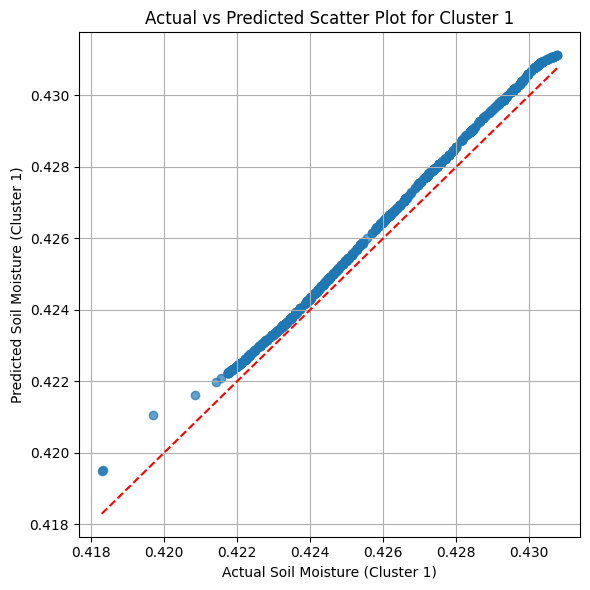


--- Training Transformer for Cluster 2 ---
  Epoch 20/100, Loss: 0.005292
  Epoch 40/100, Loss: 0.003209
  Epoch 60/100, Loss: 0.001674
  Epoch 80/100, Loss: 0.001245
  Epoch 100/100, Loss: 0.001015
R² Score for Cluster 2 on Test Set: 0.9888


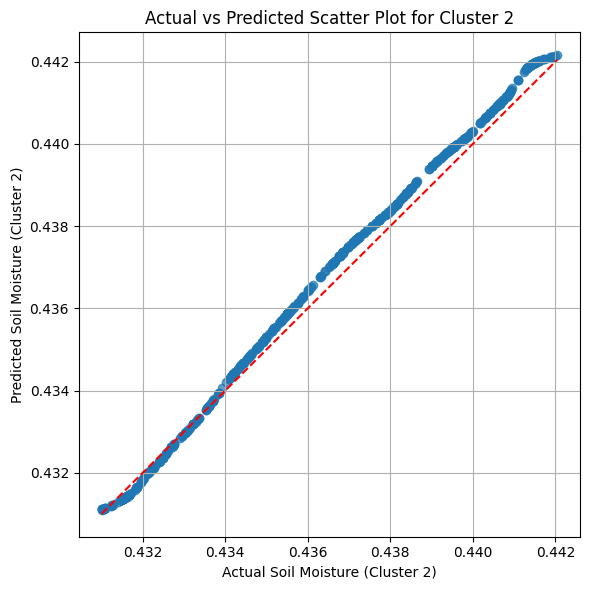


--- Training Transformer for Cluster 0 ---
  Epoch 20/100, Loss: 0.003704
  Epoch 40/100, Loss: 0.001908
  Epoch 60/100, Loss: 0.001236
  Epoch 80/100, Loss: 0.000885
  Epoch 100/100, Loss: 0.000731
R² Score for Cluster 0 on Test Set: 0.9976


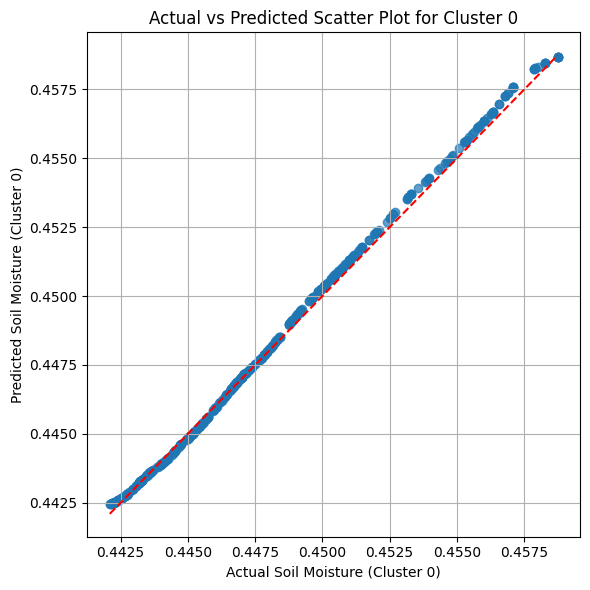


--- Training and Evaluation for all clusters completed ---

R² Scores for Clusters:
Cluster 0: R² = 0.9976
Cluster 1: R² = 0.9689
Cluster 2: R² = 0.9888


In [ ]:
# %%
# Assuming Transformer class and other necessary components are defined above
# and data1 with 'cluster' column is available from previous cells.

# Define a function to initialize weights
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    # Add initialization for MultiheadAttention layers if needed
    # if isinstance(m, nn.MultiheadAttention):
    #     # You might need more specific initialization based on the layer's structure
    #     if hasattr(m, 'in_proj_weight') and m.in_proj_weight is not None:
    #          nn.init.xavier_uniform_(m.in_proj_weight)
    #     if hasattr(m, 'out_proj') and hasattr(m.out_proj, 'weight') and m.out_proj.weight is not None:
    #          nn.init.xavier_uniform_(m.out_proj.weight)
    #     if hasattr(m, 'in_proj_bias') and m.in_proj_bias is not None:
    #          nn.init.zeros_(m.in_proj_bias)
    #     if hasattr(m, 'out_proj') and hasattr(m.out_proj, 'bias') and m.out_proj.bias is not None:
    #          nn.init.zeros_(m.out_proj.bias)


# Ensure data1 with cluster labels is available
if 'data1' not in locals():
    print("Data with cluster labels ('data1') not found. Please run the previous cell to create it.")
else:
    # Split data by cluster
    cluster_dataframes = {}
    for cluster_id in data1['cluster'].unique():
        cluster_dataframes[cluster_id] = data1[data1['cluster'] == cluster_id].copy()
        print(f"Cluster {cluster_id} has {len(cluster_dataframes[cluster_id])} data points.")

    # Dictionary to store results for each cluster
    cluster_results = {}

    # Loop through each cluster and train/evaluate a Transformer model
    for cluster_id, cluster_df in cluster_dataframes.items():
        print(f"\n--- Training Transformer for Cluster {cluster_id} ---")

        # Prepare data for this cluster
        X_cluster = cluster_df["irrigation"].values
        y_cluster = cluster_df["soil_moisture"].values

        # Check if the cluster has enough data points for train/test split (at least 2)
        if len(X_cluster) < 2:
            print(f"Cluster {cluster_id} has less than 2 data points. Skipping training for this cluster.")
            continue # Skip to the next cluster

        # Normalize for training stability (normalize within each cluster)
        X_min_cluster, X_max_cluster = X_cluster.min(), X_cluster.max()
        y_min_cluster, y_max_cluster = y_cluster.min(), y_cluster.max()

        # Handle cases where min and max are the same (all values are identical)
        # This can happen in very small clusters
        if X_max_cluster - X_min_cluster == 0:
             X_norm_cluster = np.zeros_like(X_cluster) # Or handle as appropriate for your data
        else:
             X_norm_cluster = (X_cluster - X_min_cluster) / (X_max_cluster - X_min_cluster)

        if y_max_cluster - y_min_cluster == 0:
             y_norm_cluster = np.zeros_like(y_cluster) # Or handle as appropriate for your data
        else:
             y_norm_cluster = (y_cluster - y_min_cluster) / (y_max_cluster - y_min_cluster)


        # Split data for this cluster
        # Ensure test_size is not too large for small clusters
        test_size_cluster = max(0.2, min(0.5, 1 / len(X_cluster) if len(X_cluster) > 0 else 0.2)) # Adjust test_size for very small clusters
        if len(X_cluster) >= 2: # Only split if there are enough samples
            X_train_cluster, X_test_cluster, y_train_cluster, y_test_cluster = train_test_split(
                X_norm_cluster, y_norm_cluster, test_size=test_size_cluster, random_state=42
            )
        else:
             # If not enough data for splitting, use the whole cluster for both train and test (for demonstration, not ideal for real evaluation)
             X_train_cluster, X_test_cluster = X_norm_cluster, X_norm_cluster
             y_train_cluster, y_test_cluster = y_norm_cluster, y_norm_cluster
             print(f"Cluster {cluster_id} has very few data points. Using all data for both training and testing.")


        # Create Dataset and DataLoader for this cluster
        # Ensure batch_size is not larger than the number of samples in the training set
        batch_size_cluster = min(16, len(X_train_cluster)) if len(X_train_cluster) > 0 else 1

        train_dataset_cluster = IrrigationDataset(X_train_cluster, y_train_cluster)
        test_dataset_cluster = IrrigationDataset(X_test_cluster, y_test_cluster)

        train_loader_cluster = DataLoader(train_dataset_cluster, batch_size=batch_size_cluster, shuffle=True)
        # Use batch size 1 for testing to get individual predictions
        test_loader_cluster = DataLoader(test_dataset_cluster, batch_size=1)


        # Instantiate and train Transformer model for this cluster
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model_cluster = Transformer(1, 1).to(device)

        # Apply the initialization function to the model
        model_cluster.apply(initialize_weights)

        criterion_cluster = nn.MSELoss()
        optimizer_cluster = optim.Adam(model_cluster.parameters(), lr=0.001)

        epochs_cluster = 100
        for epoch in range(epochs_cluster):
            model_cluster.train()
            epoch_loss_cluster = 0
            for src, tgt in train_loader_cluster:
                src, tgt = src.to(device), tgt.to(device)
                output = model_cluster(src, tgt)
                loss = criterion_cluster(output, tgt)
                optimizer_cluster.zero_grad()
                loss.backward()
                optimizer_cluster.step()
                epoch_loss_cluster += loss.item()
            if (epoch + 1) % 20 == 0: # Print loss less frequently for brevity
                 print(f"  Epoch {epoch+1}/{epochs_cluster}, Loss: {epoch_loss_cluster/len(train_loader_cluster):.6f}")

        # Evaluate the model for this cluster
        model_cluster.eval()
        predictions_cluster = []
        actuals_cluster = []

        with torch.no_grad():
            for src, tgt in test_loader_cluster:
                src, tgt = src.to(device), tgt.to(device)
                output = model_cluster(src, tgt)
                predictions_cluster.append(output.squeeze().cpu().item())
                actuals_cluster.append(tgt.squeeze().cpu().item())

        # Unnormalize predictions and actuals for this cluster
        predictions_cluster = np.array(predictions_cluster) * (y_max_cluster - y_min_cluster) + y_min_cluster
        actuals_cluster = np.array(actuals_cluster) * (y_max_cluster - y_min_cluster) + y_min_cluster

        # Calculate R2 Score for this cluster
        # Handle cases where actuals_cluster might have constant values (division by zero in r2_score)
        if np.std(actuals_cluster) == 0:
            r2_cluster = 1.0 if np.allclose(actuals_cluster, predictions_cluster) else 0.0 # If actuals are constant, r2 is 1 if predictions match, 0 otherwise
            print(f"R² Score for Cluster {cluster_id} on Test Set: {r2_cluster:.4f} (Actuals are constant)")
        else:
            r2_cluster = r2_score(actuals_cluster, predictions_cluster)
            print(f"R² Score for Cluster {cluster_id} on Test Set: {r2_cluster:.4f}")


        # Store results
        cluster_results[cluster_id] = {
            'actuals': actuals_cluster,
            'predictions': predictions_cluster,
            'r2': r2_cluster
        }

        # Plot Actual vs Predicted for this cluster
        plt.figure(figsize=(6, 6))
        plt.scatter(actuals_cluster, predictions_cluster, alpha=0.7)
        plt.plot([min(actuals_cluster), max(actuals_cluster)], [min(actuals_cluster), max(actuals_cluster)], 'r--')  # 45-degree reference line
        plt.xlabel(f"Actual Soil Moisture (Cluster {cluster_id})")
        plt.ylabel(f"Predicted Soil Moisture (Cluster {cluster_id})")
        plt.title(f"Actual vs Predicted Scatter Plot for Cluster {cluster_id}")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    print("\n--- Training and Evaluation for all clusters completed ---")
    # You can access results for each cluster using cluster_results dictionary
    # Example: print(cluster_results[0]['r2'])

    # Example of how to print R2 scores for specific clusters (e.g., first 3)
    print("\nR² Scores for Clusters:")
    # Assuming you have at least 3 clusters with IDs 0, 1, and 2
    for cluster_id in sorted(cluster_results.keys())[:3]: # Print for up to the first 3 cluster IDs found
        print(f"Cluster {cluster_id}: R² = {cluster_results[cluster_id]['r2']:.4f}")

In [ ]:
# ---------- Load Data and Train Overall Transformer Model ----------
from sklearn.model_selection import train_test_split

df = pd.read_csv("/content/drive/MyDrive/Soil Data/simulation_data_final.csv")  # Replace with your actual file
X = df["Irrigation"].values
y = df["SoilMoisture"].values

# Normalize for training stability (Overall Data)
X_min_overall, X_max_overall = X.min(), X.max() # These are defined here
y_min_overall, y_max_overall = y.min(), y.max() # These are defined here

# ... (rest of the overall model training code) ...

In [ ]:
# --- Ensure Overall Normalization Parameters are Accessible ---
# These should be calculated after loading the overall data but before overall normalization
# Assuming they are available from your previous overall model training block.
overall_normalization_params = {
    'X_min': X_min_overall, 'X_max': X_max_overall,
    'y_min': y_min_overall, 'y_max': y_max_overall
}

In [ ]:
# %%
# --- NEW: Hybrid Prediction Function ---

def hybrid_predict_soil_moisture(new_data_point, trained_kmeans_model, trained_overall_model, r2_overall, cluster_models, cluster_results, overall_normalization_params, cluster_normalization_params, device):
    """
    Predicts soil moisture for a new data point using a hybrid approach.
    Assigns the data point to a cluster and uses the model (overall or cluster-specific)
    with the higher R2 score on its respective test set for prediction.

    Args:
        new_data_point (np.ndarray or float): The new data point. If a float, it's assumed
                                            to be the irrigation value. If a NumPy array,
                                            it should have the same features used for clustering
                                            (ideally [[irrigation, soil_moisture]]).
        trained_kmeans_model (KMeans): The trained KMeans model for cluster assignment.
        trained_overall_model (Transformer): The trained Transformer model for the overall data.
        r2_overall (float): The R2 score of the overall model on its test set.
        cluster_models (dict): A dictionary containing the trained Transformer models for clusters.
        cluster_results (dict): A dictionary containing the evaluation results for each cluster model,
                                keyed by cluster ID and containing 'r2'.
        overall_normalization_params (dict): Dict with 'X_min', 'X_max', 'y_min', 'y_max' for overall data.
        cluster_normalization_params (dict): Dict with normalization params for each cluster.
        device (torch.device): The device to run the Transformer models on.

    Returns:
        tuple: A tuple containing:
            - float: The predicted soil moisture value.
            - int: The assigned cluster ID.
            - str: Which model was used ('Overall' or 'Cluster X').
            - float: The irrigation value of the new data point.
    """
    # Ensure new_data_point is a NumPy array
    if isinstance(new_data_point, (int, float)):
        new_irrigation_value = float(new_data_point)
        # Assume the user provides only irrigation and we need a placeholder for soil moisture
        # Use the overall mean soil moisture as a placeholder for clustering
        # You'll need to make sure `data` (your original dataframe) is accessible here
        try:
            overall_mean_soil_moisture = data['soil_moisture'].mean()
        except NameError:
            print("Error: 'data' DataFrame not found. Cannot calculate overall mean soil moisture.")
            return None, None, "None", new_irrigation_value
        new_data_point_for_clustering = np.array([[new_irrigation_value, overall_mean_soil_moisture]])
        print("Warning: Only irrigation value provided. Using overall mean soil moisture as a placeholder for clustering.")
    elif isinstance(new_data_point, np.ndarray):
         if new_data_point.ndim == 1:
             if new_data_point.shape[0] == 1:
                 new_irrigation_value = new_data_point[0]
                 try:
                    overall_mean_soil_moisture = data['soil_moisture'].mean()
                 except NameError:
                     print("Error: 'data' DataFrame not found. Cannot calculate overall mean soil moisture.")
                     return None, None, "None", new_irrigation_value
                 new_data_point_for_clustering = np.array([[new_irrigation_value, overall_mean_soil_moisture]])
                 print("Warning: 1D array provided. Using overall mean soil moisture as a placeholder for clustering.")
             else:
                 print("Error: 1D array must contain exactly one element (the irrigation value).")
                 return None, None, "None", None
         elif new_data_point.ndim == 2 and new_data_point.shape[1] == 2:
              # Correct 2D array with two features provided
              new_data_point_for_clustering = new_data_point
              new_irrigation_value = new_data_point[0, 0]
         else:
              print("Error: Invalid NumPy array shape for new_data_point. Expected 1D array (irrigation) or 2D array ([[irrigation, soil_moisture]]).")
              return None, None, "None", None
    else:
        print("Error: Invalid input type for new_data_point. Expected float or NumPy array.")
        return None, None, "None", None


    # 1. Predict the cluster for the new data point
    # Ensure trained_kmeans_model is accessible
    try:
        assigned_cluster_id = trained_kmeans_model.predict(new_data_point_for_clustering)[0]
    except NameError:
        print("Error: 'trained_kmeans_model' not found. Please ensure it's trained and accessible.")
        return None, None, "None", new_irrigation_value


    print(f"\nNew data point (Irrigation: {new_irrigation_value}) assigned to Cluster {assigned_cluster_id}")


    # 2. Get the R2 scores
    overall_r2 = r2_overall # Ensure r2_overall is accessible
    cluster_r2 = cluster_results.get(assigned_cluster_id, {}).get('r2', -float('inf')) # Ensure cluster_results is accessible

    print(f"Overall Model R² on its test set: {overall_r2:.4f}")
    print(f"Cluster {assigned_cluster_id} Model R² on its test set: {cluster_r2:.4f}")

    # 3. Choose the model with the higher R2 score
    if cluster_r2 > overall_r2:
        print(f"Using Cluster {assigned_cluster_id} Model for prediction.")
        model_to_use = cluster_models.get(assigned_cluster_id) # Ensure cluster_models is accessible
        normalization_params_to_use = cluster_normalization_params.get(assigned_cluster_id) # Ensure cluster_normalization_params is accessible
        model_used = f"Cluster {assigned_cluster_id}"

        if model_to_use is None or normalization_params_to_use is None:
             print(f"Error: Cluster {assigned_cluster_id} model or normalization params not found. Falling back to Overall model.")
             model_to_use = trained_overall_model # Ensure trained_overall_model is accessible
             normalization_params_to_use = overall_normalization_params # Ensure overall_normalization_params is accessible
             model_used = "Overall (Fallback)"

    else:
        print("Using Overall Model for prediction.")
        model_to_use = trained_overall_model
        normalization_params_to_use = overall_normalization_params
        model_used = "Overall"

    # Ensure a model is selected
    if model_to_use is None or normalization_params_to_use is None:
         print("Error: No valid model or normalization parameters found. Cannot predict.")
         return None, assigned_cluster_id, "None", new_irrigation_value


    # 4. Normalize the new irrigation value using the chosen parameters
    X_min = normalization_params_to_use['X_min']
    X_max = normalization_params_to_use['X_max']
    y_min = normalization_params_to_use['y_min'] # Needed for unnormalization
    y_max = normalization_params_to_use['y_max'] # Needed for unnormalization


    if X_max is None or X_min is None or X_max - X_min == 0:
        print(f"Warning: Irrigation range is zero or undefined in the training data for the chosen model ({model_used}). Cannot normalize.")
        # You might want to handle this case, maybe return a default value or the mean soil moisture of the chosen cluster
        return None, assigned_cluster_id, model_used, new_irrigation_value
    else:
        normalized_irrigation = (new_irrigation_value - X_min) / (X_max - X_min)


    # 5. Prepare input for the Transformer model
    # Transformer expects [batch_size, seq_len, feature_dim]
    # For a single prediction: [1, 1, 1]
    input_tensor = torch.tensor([[normalized_irrigation]], dtype=torch.float32).unsqueeze(0).to(device)

    # Provide a dummy target input for the decoder (required by your Transformer architecture)
    # For prediction of a single value, this can be a placeholder,
    # but it needs the correct shape [batch_size, seq_len, feature_dim]
    # Assuming the output dimension is 1, the shape will be [1, 1, 1]
    dummy_target_input = torch.zeros(1, 1, 1, dtype=torch.float32).to(device)


    # 6. Make the prediction
    model_to_use.eval() # Set the model to evaluation mode
    with torch.no_grad():
        predicted_normalized_output = model_to_use(input_tensor, dummy_target_input).squeeze().cpu().item()


    # 7. Unnormalize the predicted output using the chosen parameters
    predicted_soil_moisture = predicted_normalized_output * (y_max - y_min) + y_min

    return predicted_soil_moisture, assigned_cluster_id, model_used, new_irrigation_value

In [ ]:
# %%
# ---------- Load Data and Train Overall Transformer Model ----------
# ... (data loading and preparation) ...

# Instantiate and train the overall Transformer model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
overall_model = Transformer(1, 1).to(device) # This is where overall_model is defined
criterion_overall = nn.MSELoss()
optimizer_overall = optim.Adam(overall_model.parameters(), lr=0.001)

# ... (training loop) ...

# --- NEW: Store the trained overall model ---
overall_model.eval() # You are trying to use overall_model here
trained_overall_model = overall_model.cpu()

# ... (overall model evaluation code) ...

# Calculate and store R2 Score for the overall model
r2_overall = r2_score(actuals_overall, predictions_overall) # This is where r2_overall is defined
print(f"R² Score for Overall Model on Test Set: {r2_overall:.4f}")

# ... (plotting code) ...
# --- Example of how to use the hybrid prediction function ---

# Ensure all necessary components are in the global scope after running the cells:
# trained_kmeans_model, trained_overall_model, r2_overall, cluster_models, cluster_results,
# overall_normalization_params, cluster_normalization_params, device
# %%
#Hence optimum value for number of clusters is 3, as it has highest silhoutte score, ie, closest to 1,
#and it also shows shap bend at 3 for inertia curve

# --- NEW: Store the trained KMeans model ---
n_clusters = 3 # Based on your analysis
trained_kmeans_model = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
trained_kmeans_model.fit(X_clustering)  # Use the same data used for finding optimal clusters

# Get the cluster labels for each data point
cluster_labels = trained_kmeans_model.labels_

# ... (previous overall model training code) ...

# --- NEW: Store the trained overall model ---
overall_model.eval() # Set to eval mode before storing
trained_overall_model = overall_model.cpu() # Store on CPU

# ... (rest of the overall model evaluation code) ...

# ... (rest of the code in this block) ...
# Example usage with a new irrigation value
new_irrigation_value_1 = 0.000005 # Replace with your test irrigation value
predicted_soil_moisture_1, assigned_cluster_1, model_used_1, input_irrigation_1 = hybrid_predict_soil_moisture(
    new_irrigation_value_1,
    trained_kmeans_model,
    trained_overall_model,
    r2_overall,
    cluster_models,
    cluster_results,
    overall_normalization_params,
    cluster_normalization_params,
    device
)

if predicted_soil_moisture_1 is not None:
    print(f"\nFor Irrigation value {input_irrigation_1}:")
    print(f"Assigned Cluster: {assigned_cluster_1}")
    print(f"Model Used: {model_used_1}")
    print(f"Predicted Soil Moisture: {predicted_soil_moisture_1:.4f}")
else:
    print(f"\nCould not predict for Irrigation value {input_irrigation_1}.")


# Example usage with another new irrigation value
new_irrigation_value_2 = 0.00002 # Replace with another test irrigation value
predicted_soil_moisture_2, assigned_cluster_2, model_used_2, input_irrigation_2 = hybrid_predict_soil_moisture(
    new_irrigation_value_2,
    trained_kmeans_model,
    trained_overall_model,
    r2_overall,
    cluster_models,
    cluster_results,
    overall_normalization_params,
    cluster_normalization_params,
    device
)

if predicted_soil_moisture_2 is not None:
    print(f"\nFor Irrigation value {input_irrigation_2}:")
    print(f"Assigned Cluster: {assigned_cluster_2}")
    print(f"Model Used: {model_used_2}")
    print(f"Predicted Soil Moisture: {predicted_soil_moisture_2:.4f}")
else:
    print(f"\nCould not predict for Irrigation value {input_irrigation_2}.")

NameError: name 'actuals_overall' is not defined